<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework7/hw7_201216a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time 

In [2]:
# load data and only use the 'train' part of it
load = tf.keras.datasets.fashion_mnist.load_data()
print("train images",load[0][0].shape)
print("train labels",load[0][1].shape)
print("test images",load[1][0].shape)
print("test labels",load[1][1].shape)

train images (60000, 28, 28)
train labels (60000,)
test images (10000, 28, 28)
test labels (10000,)


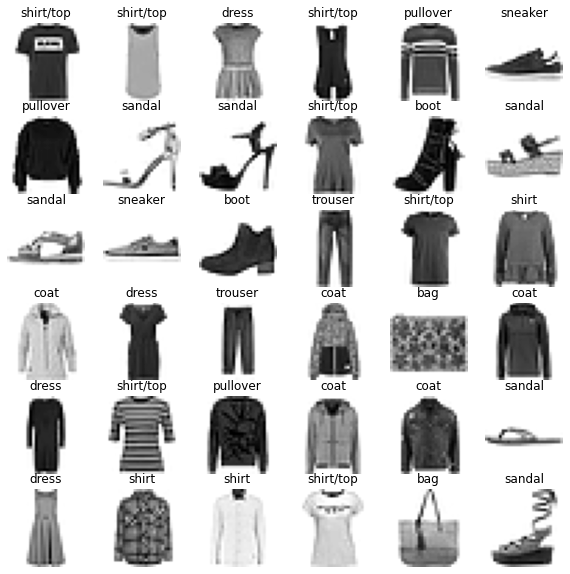

In [3]:
# plot the first entries to get an idea of the data
fig = plt.figure(figsize=(10,10))
class_names={0:'shirt/top',1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker',8:'bag', 9:'boot'}
for i in range(1,37):
  img = load[0][0][i]
  fig.add_subplot(6,6,i)
  
  plt.imshow(img, cmap="gray_r")
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title( str(class_names[int(load[0][1][i])]))

fig.show()

In [4]:
def preprocess_img(image):
  """
  normalize between 0 and 1
  """
  max = tf.math.reduce_max(image)
  min = tf.math.reduce_min(image)
  image = (image - min) / (max - min)
  image = tf.reshape(image,image.shape + (1,))
  return image

In [5]:
# Train dataset
ds_train_img = tf.data.Dataset.from_tensor_slices(load[0][0])
ds_train_img = ds_train_img.map(lambda img: preprocess_img(img))
ds_train_label = tf.data.Dataset.from_tensor_slices(load[0][1])
for entry in ds_train_label:
  print(entry)
  break;
ds_train_label = ds_train_label.map(lambda label: tf.one_hot(label, 10))
ds_train = tf.data.Dataset.zip((ds_train_img, ds_train_label))
#ds_train = ds_train.batch(64).shuffle(buffer_size=64)

# test dataset
ds_tst_img = tf.data.Dataset.from_tensor_slices(load[1][0])
ds_tst_img = ds_tst_img.map(lambda img: preprocess_img(img))
ds_tst_label = tf.data.Dataset.from_tensor_slices(load[1][1])
ds_tst_label = ds_tst_label.map(lambda label: tf.one_hot(label, 10))
ds_tst = tf.data.Dataset.zip((ds_tst_img, ds_tst_label))
#ds_tst = ds_tst.batch(64).shuffle(buffer_size=64)

print(ds_train)
print(ds_tst)

tf.Tensor(9, shape=(), dtype=uint8)
<ZipDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>
<ZipDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>


In [6]:
for entry in ds_train:
  print(entry[1])
  break;

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


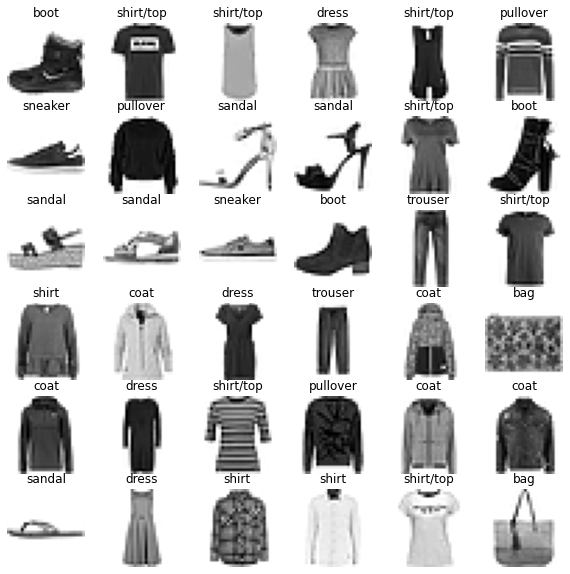

In [7]:
# re-plot the first nine entries after the mapping
def one_hot_to_int(one_hot):
  """
  reverse one hot function returning the int to the one hot vector
  """
  count = 0
  for entry in one_hot:
    if entry:
      break
    count += 1
  return count

count = 0
fig = plt.figure(figsize=(10,10))
#class_names={0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse',8:'ship', 9:'truck'}
for img in ds_train:
  count += 1
  fig.add_subplot(6,6,count)
  #print(img[0].numpy()[:,:,0])
  plt.imshow(img[0][:,:,0], cmap="gray_r")
  plt.axis('off')
  plt.title(class_names[one_hot_to_int(img[1])])
  if count == 36:
    break;
fig.show()

In [8]:
# perf batching, shuffeling and prefetching
train_ds = ds_train.batch(64).shuffle(buffer_size=64).prefetch(4)
test_ds = ds_tst.batch(64).shuffle(buffer_size=64).prefetch(4)

In [9]:
# to check the shape (here: 64 batch size and a 32x32 image with 3 colours)
for (img,label) in test_ds:
    print("image",img.shape)
    print("label",label.shape)
    break;

image (64, 28, 28, 1)
label (64, 10)


In [51]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers

class Encoder(Model):
  def __init__(self, embedding_size):
    super(Encoder, self).__init__()
    self.layer_list = [
      # 28x28x1
      layers.Conv2D(128, kernel_size = 3, strides=2, activation = None, padding ='same', input_shape=(28,28,1)),
      #layers.BatchNormalization(),
      layers.Activation('relu'),
      # 14x14xN
      layers.Conv2D(128, kernel_size = 3, strides=2, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      layers.Activation('relu'),
      # 7x7xN 
      
      #layers.Conv2D(64, kernel_size = 3, strides=2, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      #layers.Activation('relu'),
      # 4x4xN
      #layers.Conv2D(64, kernel_size = 3, strides=2, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      #layers.Activation('relu'),
      # 2x2xN 
      #layers.Conv2D(64, kernel_size = 3, strides=2, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      #layers.Activation('relu'),
      # 1x1xN
      
      layers.Flatten(),
      # N
      layers.Dense(embedding_size, activation="sigmoid")
    ]

  def call(self, x):
      for layer in self.layer_list:
        x = layer(x)
      return x

class Decoder(Model):
  def __init__(self, embedding_size):
    super(Decoder, self).__init__()
    #print("Embedding size:", shape)
    self.layer_list = [
      layers.Dense(49, activation="sigmoid", input_shape=((embedding_size,))),
      layers.Reshape((7,7,1)),
      layers.Conv2DTranspose(128,3,strides=2,activation="relu",padding='same'),
      layers.Conv2DTranspose(128,3,strides=2,activation="relu",padding='same'),
      layers.Conv2D(1,kernel_size=1,activation="sigmoid",padding="same")

    ]
  def call(self, x):
      for layer in self.layer_list:
        x = layer(x)
      return x

class Autoencoder(Model):
  def __init__(self, embedding_size):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(embedding_size)
    self.decoder = Decoder(embedding_size)

  def call(self, x, just_encode=False, just_decode=False):
    if not just_decode:
      x = self.encoder(x)
    if not just_encode:
      x = self.decoder(x)
    return x

In [63]:
x = tf.ones((64,28,28,1))
print(x.shape)
encoder = Encoder(16)
y = encoder(x)
print(y.shape)
decoder = Decoder(16)
z = decoder(y)
print(z.shape)
#z[0,:,:,0]
#plt.imshow(z[0,:,:,0])
auto = Autoencoder(16)
z2 = auto(x)
z3 = auto(x,just_encode=True)
print(z2.shape)
print(z3.shape)

(64, 28, 28, 1)
(64, 16)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 16)


In [53]:
def train_step(model, input, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    result = model(input)
    loss = loss_function(input, result)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, result

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [54]:
target = np.array([0,0,0,1])
prediction = np.array([0,0,1,0])
sample_test_accuracy = np.argmax(target) == np.argmax(prediction)
sample_test_accuracy = np.mean(sample_test_accuracy)
sample_test_accuracy

0.0

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  249232    
_________________________________________________________________
decoder (Decoder)            multiple                  149826    
Total params: 399,058
Trainable params: 399,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch: __ 0


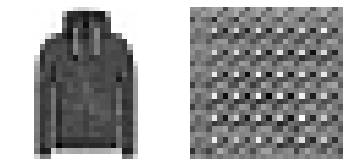

train_loss: 0.311 running: 14.4 sec ETA: 2.2 min
Epoch: __ 1


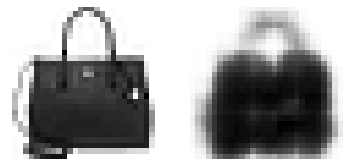

train_loss: 0.306 running: 28.8 sec ETA: 1.9 min
Epoch: __ 2


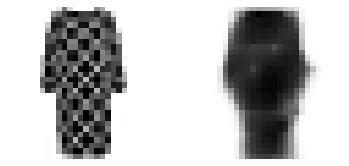

train_loss: 0.3027 running: 43.3 sec ETA: 1.7 min
Epoch: __ 3


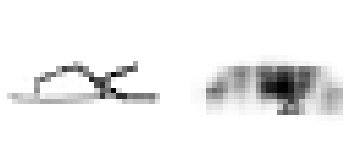

train_loss: 0.2984 running: 58.2 sec ETA: 1.5 min
Epoch: __ 4


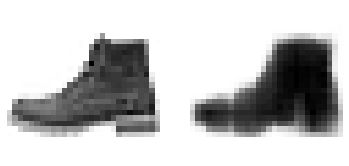

train_loss: 0.2965 running: 72.4 sec ETA: 1.2 min
Epoch: __ 5


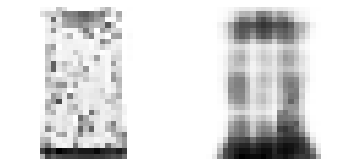

train_loss: 0.2999 running: 86.7 sec ETA: 1.0 min
Epoch: __ 6


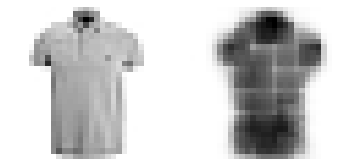

train_loss: 0.2945 running: 101.8 sec ETA: 0.7 min
Epoch: __ 7


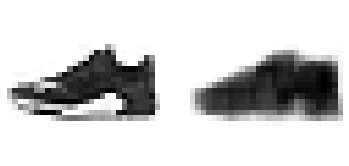

train_loss: 0.2964 running: 116.4 sec ETA: 0.5 min
Epoch: __ 8


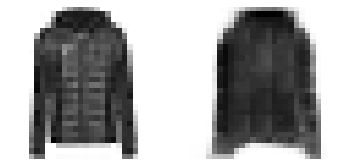

train_loss: 0.2962 running: 130.7 sec ETA: 0.2 min
Epoch: __ 9


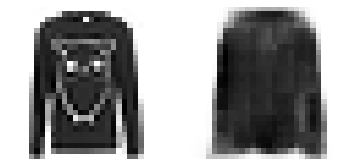

train_loss: 0.2931 running: 145.2 sec ETA: 0.0 min


In [55]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
#model = DenseNet(growth_rate=4, bottleneck=False)
#model = ResNet()
autoencoder = Autoencoder(16)

# Using binary correntropy due to values between 0 and 1
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses = []
#test_losses = []
#test_accuracies = []

#testing once before we begin
#test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)
for data in train_ds:
  autoencoder(data[0])
  break
print(autoencoder.summary())
#print("Pre-learning")
#print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6))

#check how model performs on train data once before we begin
#train_loss, _ = test(model, train_ds, cross_entropy_loss)
#train_losses.append(train_loss)

# We train for num_epochs epochs.
time0 = time.time()
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    #time1 = time.time()
    train_ds = train_ds.shuffle(buffer_size=64)
    #test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    first=True
    for (input,_) in train_ds:
        train_loss, output = train_step(autoencoder, input, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        if first:
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(input[0,:,:,0], cmap="gray_r")
          ax[1].imshow(output[0,:,:,0], cmap="gray_r")
          ax[0].axis('off')
          ax[1].axis('off')
          plt.show()
          first=False
    train_losses.append(running_average)


    #testing
    #test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    #test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)
    run_time = time.time()-time0 
    print('train_loss:', round(running_average.numpy(),4), "running:",round(run_time,1),"sec ETA:",round(((run_time)/(epoch+1)*num_epochs-run_time)/60,1),"min")



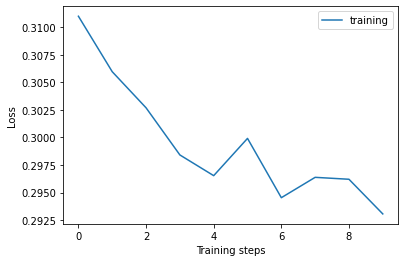

In [56]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses,label="training")
#line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [57]:
from sklearn.manifold import TSNE 
time_start = time.time()
tsne = TSNE(n_components=2)
train_sub = ds_train.batch(1000).prefetch(4)
for (img,label) in train_sub:
  embedding = autoencoder(img,just_encode=True)
  labels = label
  break
print("embedding", embedding.shape)
print("labels", labels.shape)


tsne_results = tsne.fit_transform(embedding)
tsne_results

embedding (1000, 16)
labels (1000, 10)


array([[ 23.954296 , -30.037199 ],
       [-19.661865 , -12.790127 ],
       [-26.05973  ,   6.8640833],
       ...,
       [-23.651207 ,   6.0676403],
       [ 22.940708 , -29.566578 ],
       [ 28.811876 ,   4.665097 ]], dtype=float32)

In [58]:
print(tsne_results.shape)
length = embedding.shape[0]
combined = np.zeros((length,3))
for i in range(length):
  label = one_hot_to_int(labels[i,:])
  x = tsne_results[i,0]
  y = tsne_results[i,1]
  combined[i] = (np.array([x,y,label]))
print(combined.shape)
#combined = np.reshape(combined,(3,-1))
#print(combined.shape)


(1000, 2)
(1000, 3)


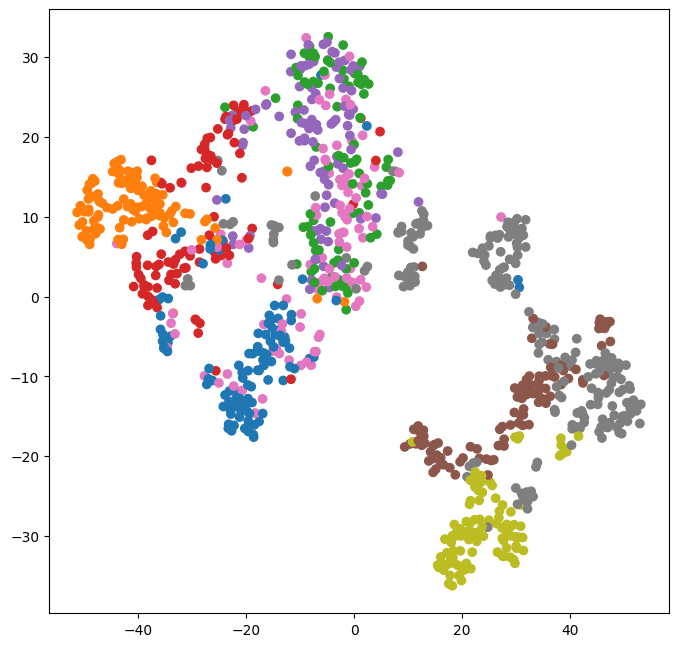

In [59]:
def get_colours(class_num):
  colours = []
  cols = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:gray","tab:olive","tab:cyan"]
  for num in class_num:
    colours.append(cols[int(num)])
  return colours
fig, ax = plt.subplots(1,figsize=(8,8), dpi=100)
ax.scatter(x=combined[:,0],y=combined[:,1], c=get_colours(combined[:,2]))
plt.show()

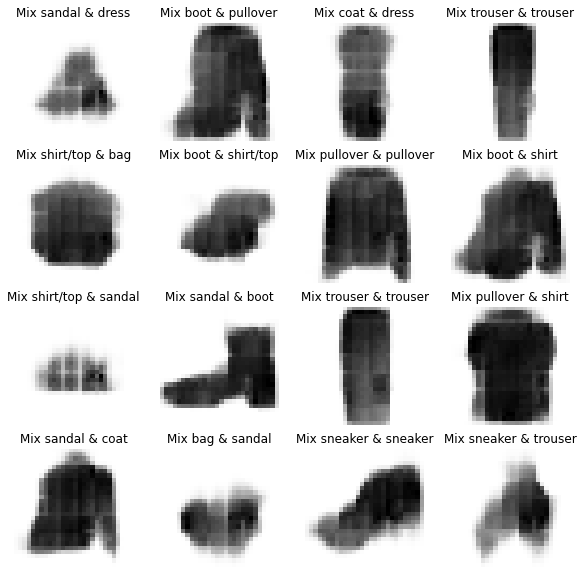

In [80]:

fig = plt.figure(figsize=(10,10))
#class_names={0:'shirt/top',1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker',8:'bag', 9:'boot'}
for i in range(1,17):
  rnd = np.random.randint(0,length+1,size=2)
  inter = (embedding[rnd[0]] + embedding[rnd[1]])/2
  inter_img = autoencoder(np.array([inter]),just_decode=True)
  fig.add_subplot(4,4,i)
  
  plt.imshow(inter_img[0,:,:,0], cmap="gray_r")
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title("Mix {} & {}".format(class_names[one_hot_to_int(labels[rnd[0]])],class_names[one_hot_to_int(labels[rnd[1]])]))

fig.show()